In [2]:
# Step 1: Imports
import pandas as pd



In [3]:
import numpy as np

In [4]:
from sklearn.decomposition import PCA


In [5]:
from sklearn.cluster import KMeans


In [6]:
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
# Adjust path to where your dataset is
data = pd.read_csv("CoV-AbDab_080224.csv")

# Inspect columns
print(data.columns)
data.head()


Index(['Name', 'Ab or Nb', 'Binds to', 'Doesn't Bind to', 'Neutralising Vs',
       'Not Neutralising Vs', 'Protein + Epitope', 'Origin', 'VHorVHH', 'VL',
       'Heavy V Gene', 'Heavy J Gene', 'Light V Gene', 'Light J Gene', 'CDRH3',
       'CDRL3', 'Structures', 'ABB Homology Model (if no structure)',
       'Sources', 'Date Added', 'Last Updated', 'Update Description',
       'Notes/Following Up?'],
      dtype='object')


,Name,Ab or Nb,Binds to,Doesn't Bind to,Neutralising Vs,Not Neutralising Vs,Protein + Epitope,Origin,VHorVHH,VL,...,Light J Gene,CDRH3,CDRL3,Structures,ABB Homology Model (if no structure),Sources,Date Added,Last Updated,Update Description,Notes/Following Up?
0,Curtis_3548_S-2,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,SARS-CoV2_WT (weak),NaN,S; RBD/non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,ARGSRNDLRDFDY,QSYNSSLSGLVV,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
1,Curtis_3548_S-7,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,NaN,SARS-CoV2_WT,S; non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,AREPYSSGMGGRDY,QQYGSSPYT,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
2,Curtis_3548_RBD-15,Ab,SARS-CoV2_WT,SARS-CoV2_Beta;SARS-CoV2_Omicron-BA1;HKU1,NaN,SARS-CoV2_WT,S; iso-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,AKGIYSSSSYWFGP,QAWDSSTVV,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Binds only non-prefusion stabilised RBD. Complete
3,8-D9,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,S; RBD,B-cells; SARS-CoV2 Human Vaccinee (BBIBP-CorV),VQLVESGGGLVQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLEW...,DIQMTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,...,IGKJ3 (Human),ARDHSGHALDI,QHLNSYPSMYT,https://www.rcsb.org/structure/8J1T;https://ww...,NaN,"Wanbo Tai et al., 2023 (https://www.nature.com...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
4,Sun_1G11,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron-BQ1;SARS-CoV2_Omicron-BQ1.1;...,S; RBD,B-cells; SARS-CoV2 Human Patient,EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...,...,IGKJ3 (Human),VKDSNYDSSGYLINNFDY,QQLYTFPVT,https://www.rcsb.org/structure/8IX3,NaN,"Hui Sun et al., 2023 (https://journals.asm.org...","Feb 8, 2024","Feb 8, 2024",NaN,Complete


In [20]:
from sgt import SGT

In [26]:
seq_col = "CDRH3"
cdr_sequences = data[seq_col].dropna().astype(str)

In [27]:
# Clean sequences
valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")

In [28]:
def clean_sequence(seq):
    seq = seq.upper()
    return "".join([aa for aa in seq if aa in valid_amino_acids])

In [29]:
cdr_sequences = cdr_sequences.apply(clean_sequence)

In [30]:
# Remove empty sequences
cdr_sequences = cdr_sequences[cdr_sequences.str.len() > 0]

In [31]:
print("Sequences after cleaning:", len(cdr_sequences))


Sequences after cleaning: 12918


In [32]:
cdr_df = pd.DataFrame({
    'id': range(len(cdr_sequences)),
    'sequence': cdr_sequences
})

In [35]:
import torch
import numpy as np
import esm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [37]:
# Load small pretrained ESM2 model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
model = model.to(device)
model.eval()
batch_converter = alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to C:\Users\ayush/.cache\torch\hub\checkpoints\esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to C:\Users\ayush/.cache\torch\hub\checkpoints\esm2_t6_8M_UR50D-contact-regression.pt


In [40]:
embeddings = []
batch_size = 64  # adjust depending on memory

model.eval()
with torch.no_grad():
    for start in range(0, len(cdr_sequences), batch_size):
        end = start + batch_size
        batch_data = [(str(i), seq) for i, seq in enumerate(cdr_sequences[start:end])]
        batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
        batch_tokens = batch_tokens.to(device)

        results = model(batch_tokens, repr_layers=[6])
        token_representations = results["representations"][6]

        # Process each sequence in the batch
        for i, (_, seq) in enumerate(batch_data):
            seq_len = len(seq)
            emb = token_representations[i, 1:seq_len+1].mean(0)
            embeddings.append(emb.cpu().numpy())

embeddings = np.stack(embeddings)
print("Embedding shape:", embeddings.shape)


Embedding shape: (12918, 320)


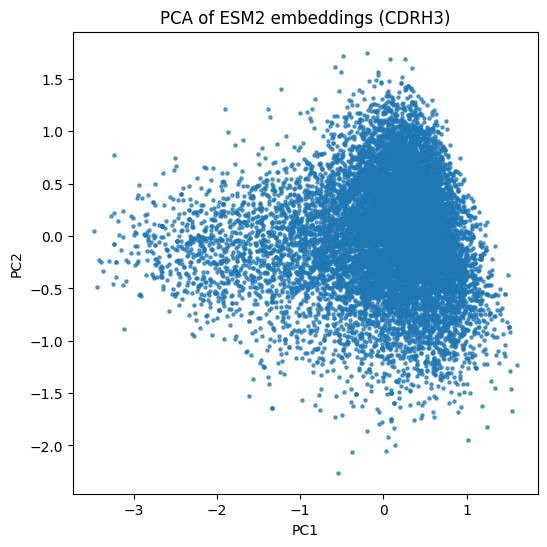

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(6, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], s=5, alpha=0.7)
plt.title("PCA of ESM2 embeddings (CDRH3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


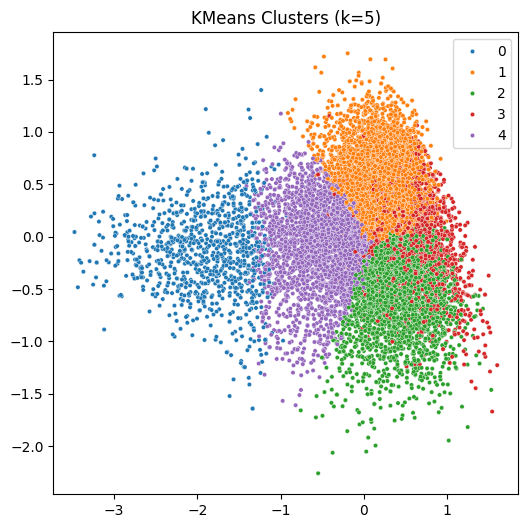

In [42]:
from sklearn.cluster import KMeans
import seaborn as sns

n_clusters = 5  # start with 5, can tune later
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette="tab10", s=10)
plt.title(f"KMeans Clusters (k={n_clusters})")
plt.show()


In [43]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(embeddings, labels)
dbi_score = davies_bouldin_score(embeddings, labels)

print("Silhouette Score:", sil_score)
print("Davies-Bouldin Index:", dbi_score)


Silhouette Score: 0.09201759845018387
Davies-Bouldin Index: 2.3502945419364214


Top labels per cluster (Protein + Epitope):

Cluster 0 (size 1031):
Protein + Epitope
S; RBD        688
S; Unk        119
S; S2          76
S; NTD         74
S; non-RBD     41
Name: count, dtype: int64

Cluster 1 (size 4050):
Protein + Epitope
S; RBD        2749
S; Unk         608
S; NTD         284
S; S2          175
S; non-RBD     115
Name: count, dtype: int64

Cluster 2 (size 2964):
Protein + Epitope
S; RBD        1914
S; Unk         439
S; S2          210
S; NTD         177
S; non-RBD     110
Name: count, dtype: int64

Cluster 3 (size 2035):
Protein + Epitope
S; RBD        1315
S; Unk         319
S; S2          162
S; NTD         106
S; non-RBD      68
Name: count, dtype: int64

Cluster 4 (size 2838):
Protein + Epitope
S; RBD        1844
S; Unk         388
S; NTD         208
S; S2          182
S; non-RBD     137
Name: count, dtype: int64

Normalized Mutual Information (0=bad, 1=perfect): 0.007327687338454169


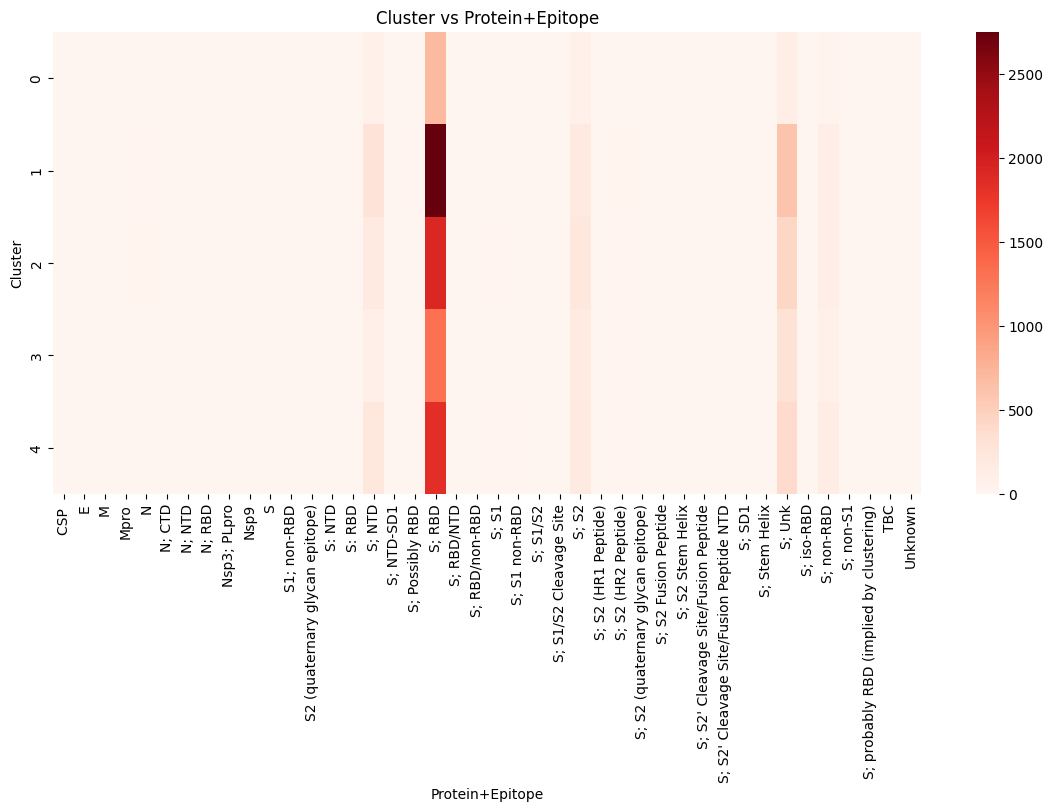

In [45]:
from sklearn.metrics import normalized_mutual_info_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure you have:
# - data (original dataframe)
# - cdr_sequences (index aligned)
# - labels (cluster assignments from KMeans)
# - n_clusters (number of clusters)

# Step 1: Align the dataframe with embeddings and cluster labels
data_filtered = data.loc[cdr_sequences.index].reset_index(drop=True)
data_filtered['cluster'] = labels

# Replace NaN in the 'Protein + Epitope' column with "Unknown"
label_series = data_filtered['Protein + Epitope'].fillna("Unknown")

# 1. Print top labels in each cluster
print("Top labels per cluster (Protein + Epitope):")
for c in range(n_clusters):
    cluster_data = data_filtered[data_filtered['cluster'] == c]
    top_labels = cluster_data['Protein + Epitope'].value_counts().head(5)
    print(f"\nCluster {c} (size {len(cluster_data)}):")
    print(top_labels)

# 2. Compute NMI score (how well clusters match labels)
nmi = normalized_mutual_info_score(label_series, labels)
print("\nNormalized Mutual Information (0=bad, 1=perfect):", nmi)

# 3. Heatmap of cluster vs labels
ct = pd.crosstab(data_filtered['cluster'], label_series)

plt.figure(figsize=(14, 6))
sns.heatmap(ct, cmap="Reds", cbar=True)
plt.title("Cluster vs Protein+Epitope")
plt.xlabel("Protein+Epitope")
plt.ylabel("Cluster")
plt.xticks(rotation=90)
plt.show()
